In [1]:
import os
import sys 
import math
# Import GPyTorch
import gpytorch

import numpy as np # linear algebra
from scipy.stats import randint
import matplotlib.pyplot as plt # this is used for the plot the graph 
%matplotlib inline
from tqdm import notebook
from scipy import stats
from scipy.interpolate import interp1d
import time

import torch

# Import GPyTorch
import gpytorch

# Import exact GP model
# ExactGP is the base class for any exact-inference Gaussian process latent function
from gpytorch.models import ExactGP

# Import GPyTorch mean and covariance kernel functions
from gpytorch.means import ConstantMean, LinearMean
from gpytorch.kernels import ScaleKernel, RBFKernel, PeriodicKernel, SpectralMixtureKernel

# Import GPyTorch distribution and likelihood
# MultivariateNormal a multivariate normal random variable
from gpytorch.distributions import MultivariateNormal
# GPyTorch likelihood specifies the mapping from latent function values observed labels
from gpytorch.likelihoods import GaussianLikelihood
# module that calculates the exact marginal log likelihood (MLL)
from gpytorch.mlls import ExactMarginalLogLikelihood
import tqdm




### Read data

In [2]:
dt=np.load('energydt.npy')

# the full design matrix
x=dt[:,:-1]
y=dt[:,-1]
ntrain=int(np.floor(len(x)*0.6))
stats.describe(y)

DescribeResult(nobs=1441, minmax=(-2.2052207299156037, 5.333679641267546), mean=-0.0032660240952695646, variance=0.985302073606261, skewness=0.5683701905151197, kurtosis=1.3028270149021273)

### GP Model

In [3]:
# Simple exact inference GP model with RBF kernel
# Inherit from GPyTorch's ExactGP base class
class RBFGP(ExactGP):
    # Exact GP initialization method
    def __init__(self, x_train, y_train, likelihood):        
        # Inherit from ExactGP
        super(RBFGP, self).__init__(x_train, y_train, likelihood)
        
        # Define mean and covariance functions
        self.mean = ConstantMean()
        self.cov = ScaleKernel(RBFKernel())

    # The forward method that takes in some n×d data x and returns a MultivariateNormal
    # with the prior mean and covariance evaluated at x
    def forward(self, x):
        # Get mean and covariance evaluated at x
        mean_x = self.mean(x)
        cov_x = self.cov(x)
        
        # Multivariate normal object
        dist = MultivariateNormal(mean_x, cov_x)
        
        # Return multivariate normal object
        return dist

### Ten Replications to evaluate the hard metrics

In [4]:
##function to create replication
def rep_iter(x,y,frac=0.4):
    n=len(x)
    ntest=int(np.floor(frac*n))
    allidx=np.random.permutation(n)
    trainidx= allidx[ntest:]
    testidx= allidx[:ntest]
    return x[trainidx],y[trainidx],x[testidx],y[testidx]
    

In [5]:
#initialize the metric
gprll=[]
gprcal=[]
gprcalshp=[] #empirical coverage
gprwidth=[] #empirical width
gpr90=[] #90 interval coverage
gprmae=[]

In [6]:
np.random.seed(2021)
for a in range(10):
    train_x,train_y,test_x,test_y=rep_iter(x,y)
    ntrain=len(train_x)
    ntest=len(test_x)

    # Convert to PyTorch tensors and place
    train_y = torch.from_numpy(train_y).float()
    train_x = torch.from_numpy(train_x).float()
    test_x = torch.from_numpy(test_x).float()
    
    # Instantiate likelihood and model
    likelihood = GaussianLikelihood()
    model = RBFGP(train_x, train_y, likelihood)
    # "Loss" for GPs - the marginal log likelihood
    # Takes likelihood and model instances as inputs
    mll = ExactMarginalLogLikelihood(likelihood, model)

    # Use the adam optimizer
    # Model parameters includes GaussianLikelihood parameters
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

    # Define number of training epochs
    n_epochs = 500

    # Place model in training mode
    model.train()
    likelihood.train()

    # Train GP model
    print('\nTraining GP with RBF kernel...\n')
    time_start = time.time()
    for epoch in range(n_epochs):
        # Zero gradients from previous iteration
        optimizer.zero_grad()

        # Output from model
        output = model(train_x)

        # Calculate loss and backpropagate gradients
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()


    # Place model and likelihood in evaluation (predictive posterior) mode
    model.eval()
    likelihood.eval()

    with torch.no_grad():
    # Make predictions by feeding model through likelihood
        observed_pred = likelihood(model(test_x))

    gprmu=observed_pred.mean.detach().numpy()
    gprstd=observed_pred.stddev.detach().numpy()   


    
    
    #####calculate metrics##############

    per=np.linspace(0.02,0.98,8) #quantile to study calibration
    pershp=np.linspace(0.4,0.999,20) #nominal quantile to study sharpness


    gprc=[]
    for i in per:
        lquantile=(stats.norm.ppf(0.5-i/2.)*gprstd+gprmu)
        rquantile=(stats.norm.ppf(0.5+i/2.)*gprstd+gprmu)
        gprc.append(np.mean((test_y.ravel()<rquantile.ravel())*(test_y.ravel()>lquantile.ravel())))

    gprcal.append(gprc)
    
    
    #sharpness
    gprc1=[]    
    gprwid=[]
    for i in pershp:
        lquantile=(stats.norm.ppf(0.5-i/2.)*gprstd+gprmu)
        rquantile=(stats.norm.ppf(0.5+i/2.)*gprstd+gprmu)
        gprc1.append(np.mean((test_y.ravel()<rquantile.ravel())*(test_y.ravel()>lquantile.ravel())))
        gprwid.append(np.median(rquantile-lquantile))
        
        
    gprcalshp.append(np.array(gprc1))    
    gprwidth.append(np.array(gprwid))
    
    #ninty
    l90=(stats.norm.ppf(0.5-0.9/2.)*gprstd+gprmu)
    r90=(stats.norm.ppf(0.5+0.9/2.)*gprstd+gprmu)
    gpr90.append(np.mean((test_y.ravel()<r90.ravel())*(test_y.ravel()>l90.ravel())))
    
    #log likelihood
    low=np.quantile(test_y,0.05)
    high=np.quantile(test_y,0.95)
    itv=np.linspace(low,high,9)
    itv=np.append(-np.infty,itv)
    itv=np.append(itv,np.infty)
    #outcome1 belongs to which interval
    id=np.zeros(len(test_y))
    for i in range(10):
        id=id+1*(test_y.ravel()>itv[i+1])
    id=id.astype('int')

    l=(itv[id]-gprmu)/gprstd
    r=(itv[id+1]-gprmu)/gprstd
    prtmp=stats.norm.cdf(r)-stats.norm.cdf(l)
    ll_est=np.log(prtmp)
    gprll.append(ll_est.mean())
    
    #mae
    gprmae.append(np.abs(gprmu-test_y.ravel()).mean()) #regular def
    




Training GP with RBF kernel...


Training GP with RBF kernel...


Training GP with RBF kernel...


Training GP with RBF kernel...


Training GP with RBF kernel...


Training GP with RBF kernel...


Training GP with RBF kernel...


Training GP with RBF kernel...


Training GP with RBF kernel...


Training GP with RBF kernel...



In [7]:
def musd(x):
    print(np.mean(x),np.std(x))

musd(gprll)
musd(gpr90)
musd(gprmae)



-1.8504079138171228 0.024215512872858596
0.8965277777777778 0.015628857548509567
0.5476382677569287 0.016177655668370716


In [8]:
#calibration
def calcompu(x):
    x=np.array(x)
    n=len(x)
    cal=np.mean(x,0)
    calest=np.abs(x-per).mean(1)
    
    print(np.mean(calest),np.std(calest))
    
    return  cal

gprcalplot=calcompu(gprcal)

0.03526252480158726 0.010079081725333432


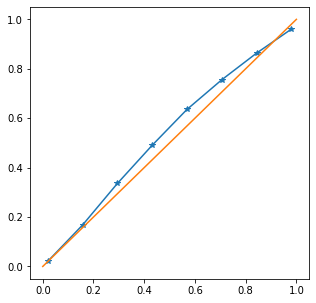

In [16]:
## calibration plot
plt.figure(figsize=(5,5))
plt.plot(per,gprcalplot,'-*')

plt.plot([0,1],[0,1])

In [11]:
def shpplt(cal,width): #average interval width calculation
    n=len(cal)
    cal=np.array(cal)
    width=np.array(width)
    low=np.max(cal[:,0])
    up=np.min(cal[:,-1])
    rangeint=np.linspace(low,up,30)
    widest=[]
    for i in range(n):
        widest.append(interp1d(cal[i],width[i])(rangeint))
    
    return rangeint,np.array(widest).mean(0)

    

In [12]:
gprempcal,gprempwid=shpplt(gprcalshp,gprwidth)

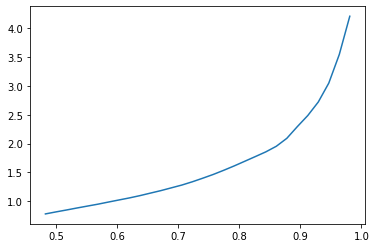

In [13]:
plt.plot(gprempcal,gprempwid)